### Poultry Diseases Detection - `MOBILENETV3`

In this notebook we are going to train a model with the help of transfare learning on the `MOBILENETV3` achitecture that does  Poultry Diseases Detection diagonisis based on `feaces` images  of poultry using the dataset that was obtained from kaggle at this url:

> https://www.kaggle.com/datasets/kausthubkannan/poultry-diseases-detection


In the following code cell we are going to install the `helperfns` package that contains some helper functions that we are going to use in this notebook.

In [1]:
!pip install helperfns pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 48.5 MB/s eta 0:00:00


In the following code cell we are going to import all the packages that we are going to use for the rest of this notebook.

In [2]:
import torch
import random
import os
import time
import torchvision
import copy
import json
from pigmenta import PALETTES

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import FileLink
from shutil import copyfile
from google.colab import drive
from torch.nn import functional as F
from PIL import Image
from torchvision import datasets, transforms
from torch.utils import data
from PIL import Image
from sklearn.metrics import classification_report
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.utils import hms_string

from helperfns import visualization
from torchvision import models
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


torch:  2.6.0+cu124
numpy:  2.0.2
pandas:  2.2.2


In the next code cell we are then going to mount the google drive so that we can have access to the data that was uploaded there:


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


### Seed

In the following code cell we are going to define the `SEED` for all random operation for reproducivity of results in this notebook.

In [5]:
SEED = 23

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

In the following code cell we are going to create a variable `device` that will hold the value of the device that is available so that we can have access to the `GPU` if available.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset

The dataset that we will be using to train our model was found on Kaggle with the following URL:

> https://www.kaggle.com/datasets/kausthubkannan/poultry-diseases-detection


We are going to load the dataset from google drive. In the following code cell we are going to define the path to the dataset images.


In [7]:
base_path = "/content/drive/MyDrive/Poultry Diseases Detection"

assert os.path.exists(base_path), f"The path '{base_path}' does not exists."

In the next code cell we are going to create a dataset folder that will have the following folder names:

1. `coccidiosis `
2. `salmonella `
3. `newcastle`
4. `healthy`


These are the class categorioes that we will be predicting.

In [8]:
os.listdir(base_path)

['salmo', 'ncd', 'healthy', 'cocci']

In [9]:
if not os.path.exists("dataset/coccidiosis"):
  os.makedirs("dataset/coccidiosis")

if not os.path.exists("dataset/salmonella"):
  os.makedirs("dataset/salmonella")

if not os.path.exists("dataset/newcastle"):
  os.makedirs("dataset/newcastle")

if not os.path.exists("dataset/healthy"):
  os.makedirs("dataset/healthy")

print("Done!")

Done!


In the following code cell we are going to take the first `1000` images in each class and copy them in our dataset folder respective to the classes that were created. From the original dataset the class `ncd` had `376` and the rest of the classes were having images that were more than `2000`

In [10]:
for image in os.listdir(os.path.join(base_path, 'salmo'))[:1000]:
  copyfile(os.path.join(base_path, 'salmo', image), os.path.join("dataset/salmonella", image))

for image in os.listdir(os.path.join(base_path, 'cocci'))[:1000]:
  copyfile(os.path.join(base_path, 'cocci', image), os.path.join("dataset/coccidiosis", image))

for image in os.listdir(os.path.join(base_path, 'ncd'))[:1000]:
  copyfile(os.path.join(base_path, 'ncd', image), os.path.join("dataset/newcastle", image))

for image in os.listdir(os.path.join(base_path, 'healthy'))[:1000]:
  copyfile(os.path.join(base_path, 'healthy', image), os.path.join("dataset/healthy", image))

print("Done!")

Done!


### Channels Means and STDs

In the following code cell we are going to compute the means and standard deviations of all color channels in all images in the dataset so that we can use them to normalize the images during transformations.

In [11]:
data_path = "dataset"

pretrained_size = 224
train_data = datasets.ImageFolder(
    root=data_path,
    transform= transforms.Compose([
        transforms.Resize(pretrained_size), # calculate means for the resized images according to the pretrained image size.
        transforms.ToTensor()
      ])
    )

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
  means += torch.mean(img, dim = (1,2))
  stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')


Calculated means: tensor([0.5892, 0.5628, 0.5127])
Calculated stds: tensor([0.1514, 0.1529, 0.1645])


Since we will be using the `MOBILENETV3` for transfare learning we are going to use the pretrained size that this model expect which is `224`. For the means and standard deviation we are going to use the ones that we computed in the previous code cell for image normalization.

In [12]:
image_transforms = {
    "train": transforms.Compose([
            transforms.Resize(pretrained_size),
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop(pretrained_size, padding = 10),
            transforms.ToTensor(),
            transforms.Normalize(mean = means,
                                std = stds)
          ]),
    "valid": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = means,
                            std = stds)
        ]),
    "test": transforms.Compose([
          transforms.Resize((pretrained_size, pretrained_size)),
          transforms.ToTensor(),
          transforms.Normalize(mean = means,
                            std = stds)
    ])
}

In the following code cell we are then going to create a dataset `Poultry Diseases Detection` using the `ImageFolder` class that will map our classes to the respective images and handles a lot of work for us.

In [13]:
feces_dataset = datasets.ImageFolder(data_path, transform = image_transforms['train'])
class_names = feces_dataset.classes
class_names

['coccidiosis', 'healthy', 'newcastle', 'salmonella']

We can check the class to index mapping of the dataset as follows..

In [14]:
feces_dataset.class_to_idx

{'coccidiosis': 0, 'healthy': 1, 'newcastle': 2, 'salmonella': 3}

### Validation and Test Splits

Next we are going to take `20%` the training and validation data from the training data.

In [15]:
VALID_RATIO = 0.2
TEST_RATIO = 0.2

# Split into train + test
n_test_examples = int(len(feces_dataset) * TEST_RATIO)
n_train_examples = len(feces_dataset) - n_test_examples
train_data, test_data = data.random_split(feces_dataset,
                                          [n_train_examples, n_test_examples])

# Split the training data into train + validation
n_valid_examples = int(len(train_data) * VALID_RATIO)
n_train_examples = len(train_data) - n_valid_examples
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])


> Note that after spliting the train dataset into 2 subsets these 2 subsets will contain transforms of the train data. So we need to overide them. For that we are going to create a copy and overide the train transforms with respective transforms for each set.

In [16]:
valid_data = copy.deepcopy(valid_data)
test_data = copy.deepcopy(test_data)

valid_data.dataset.transform = image_transforms['valid']
test_data.dataset.transform = image_transforms['test']

In the following code cell we are going to use the pie chat to visualize the examples that we have in each subset.

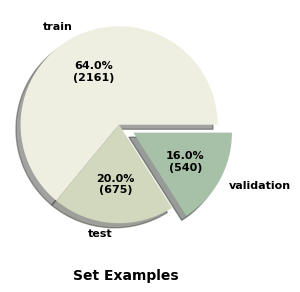

In [17]:
plt.figure(figsize=(3, 3))

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.pie(
    [len(train_data), len(test_data), len(valid_data)], explode= [.0, .0, .1],
    labels=['train', 'test', 'validation'],
    pctdistance=0.6, shadow=True, autopct=lambda x: fmt(x, len(feces_dataset)),
    textprops={'color': 'black', 'fontsize': 8, 'weight': 'bold'},
    radius=.6, colors=PALETTES.earth
)
plt.xlabel('Set Examples', weight="bold", fontsize=10, labelpad=20)
plt.axis('equal')
plt.show()

Next we are going to create iterators and we are going to set the batch size to be `64`.

In [18]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size= BATCH_SIZE
)
valid_iterator = data.DataLoader(
    valid_data, batch_size= BATCH_SIZE
)
test_iterator = data.DataLoader(
    test_data,  batch_size= BATCH_SIZE
)

### Visualizing Images

In this section of the notebook we are going to visualize the images that we have in our dataset with their respective labels.

In [19]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

Next we are going to define the `plot_images` function which is responsible for plotting images.

In [20]:
def plot_images(images, labels, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(class_names[labels[i]], fontsize=10, color='g' if labels[i] == 1 else 'r')
    ax.axis('off')


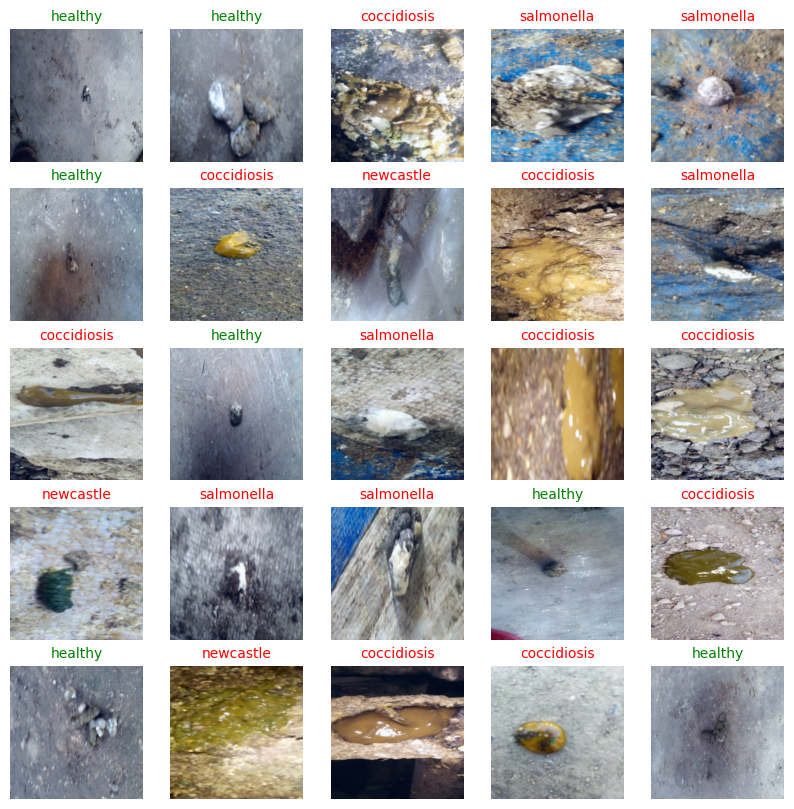

In [21]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                           [test_data[i] for i in range(N_IMAGES)]])
plot_images(images, labels)

### Pretrained `MOBILENETV3`

In the following code cell we are going to load the `MOBILENETV3` model with it's weight.

In [22]:
mobilenetv3 = models.mobilenet_v3_large(weights = True).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 49.7MB/s]


Next we are going to define the output dimension that matches the labels of our task.


> Note that we are not going to freeze the model in this case because we want to retrain the model and be able to update the weights to get the better results.

In [23]:
OUTPUT_DIM = 1 if len(class_names) == 2 else len(class_names)
def freeze_model(model):
  for param in model.parameters():
    param.requires_grad = False

Next we are going to update the output layer of our `MOBILENETV3` to match the output size of `4` since we are doing a multi-class classification on feces images.

In [24]:
mobilenetv3.classifier[-1] = nn.Linear(mobilenetv3.classifier[-1].in_features, OUTPUT_DIM).to(device)

Next we are going to create a function that will count the model parameters.

In [25]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  return f'{total_params:,}', f'{trainable_params:,}', f'{total_params - trainable_params:,}'

Then we will visualize the model parameters using a table.

In [26]:
tabulate_data(
    ["NAME", "TOTAL PARAMETERS", "TRAINABLE PARAMETERS", "NON-TRAINABLE PARAMETERS"],
    [
      ['MOBILENETV3', *count_params(mobilenetv3)],
    ],
    "MODELS' PARAMETERS"
)


MODELS' PARAMETERS
+-------------+------------------+----------------------+--------------------------+
| NAME        | TOTAL PARAMETERS | TRAINABLE PARAMETERS | NON-TRAINABLE PARAMETERS |
+-------------+------------------+----------------------+--------------------------+
| MOBILENETV3 |        4,207,156 |            4,207,156 |                        0 |
+-------------+------------------+----------------------+--------------------------+


### Criterion and Optmizer

Next we are going to define the optmizer to be `Adam` with default parameters and the loss function to be `BCELossWithLogitsLoss` since it is a binary classification task.

In [27]:
optimizers = {
    'mobilenetv3': torch.optim.Adam(mobilenetv3.parameters())
}
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to define our `categorical_accuracy` function which is a function that caculate the categorical accuracy between predicted labels and real labels.

In [28]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Train and Evaluate Functions

In the following code cell we are going to define the `train` and `evaluate` fuctions.

In [29]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).long()
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device).long()
      y_pred = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

Next we are going to create a `History` wrapper class so that we can keep in track of the model's metrics during training.

In [30]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

Next we are going to define the `train_model` function which is responsible for training the model and return model training history.

In [31]:
EPOCHS = 10
def train_model(model, model_name, train_iterator, optimizer, criterion, device, valid_iterator):
  best_valid_loss = float('inf')
  column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
  last_saved_epoch = 1

  history = History()
  training_start = time.time()
  for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    save_status = "(not saving)"
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      save_status = "(saving)"
      last_saved_epoch = epoch + 1
      torch.save(model.state_dict(), model_name)

    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


    data_rows = [
        ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
    ]

    title = f"{model_name.replace('.pt', '')}: EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
    tabulate_data(column_names, data_rows, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

Next we are going to run the train loop.

In [32]:
mobilenetv3_history, mobilenetv3_training_end, mobilenetv3_last_saved_epoch = train_model(
    mobilenetv3, 'mobilenetv3.pt', train_iterator, optimizers['mobilenetv3'], criterion, device, valid_iterator
)

mobilenetv3: EPOCH 01/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.301 |   88.70% | 0:03:08.95 |
| Validation | 0.212 |   93.60% |            |
+------------+-------+----------+------------+
mobilenetv3: EPOCH 02/10: (not saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.094 |   96.56% | 0:02:50.18 |
| Validation | 0.292 |   94.62% |            |
+------------+-------+----------+------------+
mobilenetv3: EPOCH 03/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.073 |   97.37% | 0:02:49.59 |
| Validation | 0.170 |   96.35% |            |
+------------+-------+----------+------------+
mobilenetv3: EPOCH 04/10: (not saving)
+-----

### Model Training Time.

In the following code cell, using a table we are going to visualize the model's total training time and last saved epoch.

In [33]:
rows = [
    ['mobilenetv3', f'{EPOCHS}', f'{hms_string(mobilenetv3_training_end)}', f'{mobilenetv3_last_saved_epoch}']
]
tabulate_data(['MODEL','TOTAL EPOCHS', 'TOTAL TRAINING TIME', 'LAST SAVED EPOCH'], rows, "TOTAL TRAINING TIME")

TOTAL TRAINING TIME
+-------------+--------------+---------------------+------------------+
| MODEL       | TOTAL EPOCHS | TOTAL TRAINING TIME | LAST SAVED EPOCH |
+-------------+--------------+---------------------+------------------+
| mobilenetv3 |           10 |          0:28:43.92 |                8 |
+-------------+--------------+---------------------+------------------+


In the following code cell we are then going to visualize the model's training time per epoch/

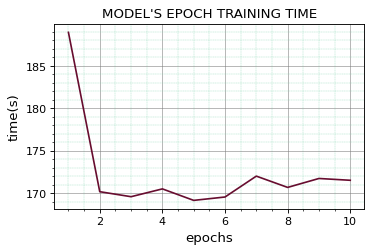

In [34]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, mobilenetv3_history.epoch_train_time, label="mobilenetv3", color=PALETTES.dark[6])
plt.title("MODEL'S EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Validation and Training Accuracies

In the following code cell we are going to visualize the model's training and validation accuracies per epoch using line graphs

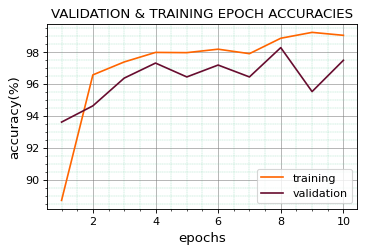

In [35]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [i * 100 for i in mobilenetv3_history.train_acc], label="training", color=PALETTES.dark[55])
plt.plot(epochs, [i * 100 for i in mobilenetv3_history.val_acc], label="validation", color=PALETTES.dark[6])
plt.title("VALIDATION & TRAINING EPOCH ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Validation and Training Losses

In the following code cell we are going to visualize the model's training and validation losses per epoch using line graphs

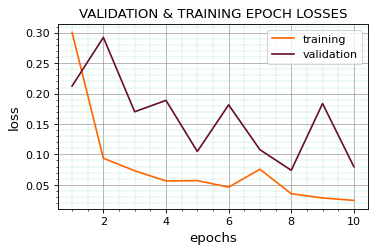

In [36]:
plt.figure(figsize=(5, 3), dpi=80)

plt.plot(epochs, mobilenetv3_history.train_losses, label="training", color=PALETTES.dark[55])
plt.plot(epochs, mobilenetv3_history.val_losses, label="validation", color=PALETTES.dark[6])

plt.title("VALIDATION & TRAINING EPOCH LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Best Model Evaluation

In the following code cell we are going to create a function that will evaluate the best saved model during training interms of loss and accuracy based on the testing dataset.

In [37]:
def evaluate_best_model(model, model_name, test_iterator, criterion, device):
  model.load_state_dict(torch.load(model_name, weights_only=True))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  return f'{test_loss:.2f}', f'{test_acc * 100:.2f}'


tabulate_data(
    ["NAME", "LOSS", "ACCURACY (%)"],
    [
        ['MOBILENETV3', *evaluate_best_model(mobilenetv3, 'mobilenetv3.pt', test_iterator, criterion, device)],
    ],
    "BEST MODEL'S LOSS AND ACCURACY"
)

BEST MODEL'S LOSS AND ACCURACY
+-------------+------+--------------+
| NAME        | LOSS | ACCURACY (%) |
+-------------+------+--------------+
| MOBILENETV3 | 0.16 |        96.07 |
+-------------+------+--------------+


### Model Evaluation metrics
In this section we are going to evaluate the best model and visualize the matrics. We are going to use the following evaluation methods on this classification task.

1. confusion matrix
2. classification report.


First we need to get all the predictions from the train dataset.

In [ ]:
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

test_images, test_labels, probs = get_predictions(mobilenetv3, test_iterator, device)

Next we are going to convert our predictions from probabilities to real labels.

In [ ]:
preds = torch.argmax(probs, 1).numpy().astype(np.int32)
test_labels = test_labels.numpy()

### Plotting Predictions

In this section we are going to plot the predictions.

In [ ]:
test_images_labels = list(zip(test_images, preds, test_labels))
random.shuffle(test_images_labels)
y_true = []
y_pred = []
images = []

for img, pred, label in test_images_labels[:24]:
  y_true.append(label)
  y_pred.append(pred)
  images.append(img)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

Next we are going to define the function that will plot the predictions for us.

In [ ]:
def plot_predictions_images(images_and_classes,
                            labels_true, labels_pred,
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        image = normalize_image(image)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title(class_names[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=10 )

plot_predictions_images(images[:24], y_true[:24], y_pred[:24], cols=8)


### Confusion Matrix

In the following code cell we are going to visualize the confusion matrix of our model based on the test dataset.

In [ ]:
plot_complicated_confusion_matrix(test_labels, preds, class_names,
                                  fontsize=8, figsize=(5, 5), title="MOBILENETV3: Confusion Matrix")

### Classification Report

In the following code cell we are going to print the classification report of our best model based on the test datast.

In [43]:
cr = classification_report(test_labels, preds, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       218
           1       0.95      0.96      0.96       169
           2       0.85      0.93      0.89        81
           3       0.99      0.96      0.98       207

    accuracy                           0.96       675
   macro avg       0.95      0.96      0.95       675
weighted avg       0.96      0.96      0.96       675



In the following code cell we are going to the plot the confusion matrix.

In [ ]:
fig, ax = visualization.plot_classification_report(test_labels, preds,
                    title='MOBILENETV3: Classification Report',
                    figsize=(10, 5), dpi=70,
                    target_names = class_names)

### Mis Predicted Feces

In this section we are going to plot the mispredicted images of Feces if there are available.

In [45]:
corrects = torch.eq(torch.from_numpy(test_labels), torch.from_numpy(preds))

In [46]:
def get_incorrect_examples(images, labels, probabilities, corrects):
  incorrect_examples = []
  for image, label, prob, correct in zip(images, labels, probabilities, corrects):
    if not correct:
      incorrect_examples.append((image, label, prob))
  return incorrect_examples

incorrect_examples = get_incorrect_examples(test_images, test_labels, probs, corrects)

In [47]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (6, 4))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    image = image.permute(1, 2, 0)
    true_class = classes[true_label]
    incorrect_class = classes[0 if true_label == 1 else 1]
    if normalize:
      image = normalize_image(image)
    ax.imshow(image.cpu().numpy())
    ax.set_title(f'real: {true_class}\n' \
                  f'predicted: {incorrect_class}', fontsize=8)
    ax.axis('off')
  fig.subplots_adjust(hspace=0.4)

In the following code cell we are going to plot the most mispredicted `Feces` images by the model.

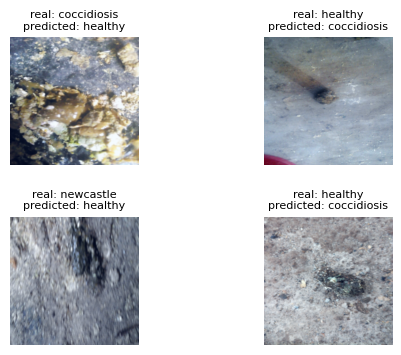

In [48]:
N_IMAGES = 8
try:
    plot_most_incorrect(incorrect_examples, class_names, N_IMAGES)
except:
    print("No incorrectly Predicted Images")

### Model Inference

In this section we are going to load one of the images from the file system and create a function that will make predictions using our model based on that image.

In [49]:
health_image = os.path.join(
    data_path, 'healthy', os.listdir(os.path.join(data_path, 'healthy'))[0]
)
coccidiosis_image = os.path.join(
    data_path, 'coccidiosis', os.listdir(os.path.join(data_path, 'coccidiosis'))[0]
)
newcastle_image = os.path.join(
    data_path, 'newcastle', os.listdir(os.path.join(data_path, 'newcastle'))[0]
)
salmonella_image = os.path.join(
    data_path, 'salmonella', os.listdir(os.path.join(data_path, 'salmonella'))[0]
)

Next we are going to define a function that will process the image by transforming it using the `test` transforms.

In [50]:
def preprocess_img(img:str):
  """
  takes in an image path and pre process it
  """
  img = image_transforms['test'](Image.open(img).convert('RGB'))
  return img

The following function will then make predictions using the model and give a prediction response.

In [51]:
class Prediction:
    def __init__(self, label:int, probability:float, type_: str) -> None:
        self.label = label
        self.probability = probability
        self.type_ = type_

    def __repr__(self) -> str:
        return f"[{self.type_}]"

    def __str__(self) -> str:
        return f"[{self.type_}]"

    def to_json(self):
        return {
            "label": int(self.label),
            "probability": float(self.probability),
            "type": self.type_,
        }

class Response:
    def __init__(self, top_prediction: Prediction, predictions:list) -> None:
        self.predictions = predictions
        self.top_prediction = top_prediction

    def __repr__(self) -> str:
        return f"[Fece Prediction Response - {self.top_prediction.type_}]"

    def __str__(self) -> str:
        return f"[Fece Prediction Response - {self.top_prediction.type_}]"

    def to_json(self):
        return{
           "predictions": [item.to_json() for item in self.predictions],
            "top_prediction": self.top_prediction.to_json()
        }


In [53]:
def predict_disease(model, image, device):
    image = preprocess_img(image).to(device)
    model.eval()
    with torch.no_grad():
      image = image.unsqueeze(dim=0).to(device)
      preds = model(image)
      preds = F.softmax(preds, dim=1).detach().cpu().numpy().squeeze()
      predicted_label = np.argmax(preds)
      predictions = [
        Prediction(
              label= i,
              type_ = class_names[i],
              probability = np.round(preds[i], 2)
          ) for i, _ in enumerate(preds)
      ]
      predicted = Prediction(
          label= predicted_label,
          type_ = class_names[predicted_label],
          probability = np.round(preds[predicted_label], 2)
      )
      return Response(
          top_prediction = predicted,
          predictions = predictions
      )

Predicting the `Health Fece` image.

In [54]:
predict_disease(mobilenetv3, health_image, device).to_json()

{'predictions': [{'label': 0, 'probability': 0.0, 'type': 'coccidiosis'},
  {'label': 1, 'probability': 1.0, 'type': 'healthy'},
  {'label': 2, 'probability': 0.0, 'type': 'newcastle'},
  {'label': 3, 'probability': 0.0, 'type': 'salmonella'}],
 'top_prediction': {'label': 1, 'probability': 1.0, 'type': 'healthy'}}

Predcicting the `Salmonella Fece`  image.

In [55]:
predict_disease(mobilenetv3, salmonella_image, device).to_json()

{'predictions': [{'label': 0, 'probability': 0.0, 'type': 'coccidiosis'},
  {'label': 1, 'probability': 0.0, 'type': 'healthy'},
  {'label': 2, 'probability': 0.0, 'type': 'newcastle'},
  {'label': 3, 'probability': 1.0, 'type': 'salmonella'}],
 'top_prediction': {'label': 3, 'probability': 1.0, 'type': 'salmonella'}}

Predcicting the `Newcastle Fece`  image.

In [56]:
predict_disease(mobilenetv3, newcastle_image, device).to_json()

{'predictions': [{'label': 0, 'probability': 0.0, 'type': 'coccidiosis'},
  {'label': 1, 'probability': 0.0, 'type': 'healthy'},
  {'label': 2, 'probability': 1.0, 'type': 'newcastle'},
  {'label': 3, 'probability': 0.0, 'type': 'salmonella'}],
 'top_prediction': {'label': 2, 'probability': 1.0, 'type': 'newcastle'}}

Predcicting the `Coccidiosis Fece`  image.

In [57]:
predict_disease(mobilenetv3, coccidiosis_image, device).to_json()

{'predictions': [{'label': 0, 'probability': 1.0, 'type': 'coccidiosis'},
  {'label': 1, 'probability': 0.0, 'type': 'healthy'},
  {'label': 2, 'probability': 0.0, 'type': 'newcastle'},
  {'label': 3, 'probability': 0.0, 'type': 'salmonella'}],
 'top_prediction': {'label': 0, 'probability': 1.0, 'type': 'coccidiosis'}}